Dataset shape: (11000, 347, 1)
Labels distribution: (array([0, 1]), array([2200, 8800]))
🎲 Random state used for this run: 8316

🔹 Fold 1
Train: 14492, Val: 1554, Test: 2200


c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 341, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 341, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 170, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 170, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 166, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 166, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 81, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 81, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,793 (350.75 KB)

 Trainable params: 89,345 (349.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.4872 - loss: 0.3790 - val_accuracy: 0.8018 - val_loss: 0.3260
Epoch 2/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7374 - loss: 0.2629 - val_accuracy: 0.9331 - val_loss: 0.1197
Epoch 3/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9472 - loss: 0.1062 - val_accuracy: 0.9530 - val_loss: 0.1004
Epoch 4/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9593 - loss: 0.0756 - val_accuracy: 0.9479 - val_loss: 0.1147
Epoch 5/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9623 - loss: 0.0692 - val_accuracy: 0.9614 - val_loss: 0.0836
Epoch 6/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9682 - loss: 0.0624 - val_accuracy: 0.9691 - val_loss: 0.0648
Epoch 7/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9707 - loss: 0.0516 - val_accuracy: 0.9640 - val_loss: 0.0815
Epoch 8/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9711 - loss: 0.0495 - val_ac

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 341, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 341, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 170, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 170, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 166, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 166, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 81, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 81, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,793 (350.75 KB)

 Trainable params: 89,345 (349.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.4476 - loss: 0.3769 - val_accuracy: 0.5701 - val_loss: 0.3629
Epoch 2/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.7581 - loss: 0.2540 - val_accuracy: 0.9595 - val_loss: 0.1071
Epoch 3/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9496 - loss: 0.1000 - val_accuracy: 0.9762 - val_loss: 0.0587
Epoch 4/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9569 - loss: 0.0787 - val_accuracy: 0.9730 - val_loss: 0.0611
Epoch 5/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9647 - loss: 0.0631 - val_accuracy: 0.9775 - val_loss: 0.0451
Epoch 6/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9666 - loss: 0.0568 - val_accuracy: 0.9762 - val_loss: 0.0504
Epoch 7/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9723 - loss: 0.0465 - val_accuracy: 0.9781 - val_loss: 0.0416
Epoch 8/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9743 - loss: 0.0501 - val_acc

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 341, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 341, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 170, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 170, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 166, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 166, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 81, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 81, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,793 (350.75 KB)

 Trainable params: 89,345 (349.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5237 - loss: 0.3728 - val_accuracy: 0.8275 - val_loss: 0.2782
Epoch 2/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8466 - loss: 0.1917 - val_accuracy: 0.9369 - val_loss: 0.1266
Epoch 3/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9515 - loss: 0.0852 - val_accuracy: 0.9434 - val_loss: 0.1189
Epoch 4/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9602 - loss: 0.0697 - val_accuracy: 0.9524 - val_loss: 0.1066
Epoch 5/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9678 - loss: 0.0585 - val_accuracy: 0.9556 - val_loss: 0.1119
Epoch 6/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9715 - loss: 0.0525 - val_accuracy: 0.9685 - val_loss: 0.0754
Epoch 7/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9725 - loss: 0.0487 - val_accuracy: 0.9685 - val_loss: 0.0784
Epoch 8/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9722 - loss: 0.0466 - val_ac

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 341, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 341, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 170, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 170, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 166, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 166, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 81, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 81, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,793 (350.75 KB)

 Trainable params: 89,345 (349.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.4927 - loss: 0.3666 - val_accuracy: 0.8488 - val_loss: 0.2959
Epoch 2/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.8539 - loss: 0.1953 - val_accuracy: 0.9595 - val_loss: 0.0882
Epoch 3/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9510 - loss: 0.0926 - val_accuracy: 0.9691 - val_loss: 0.0701
Epoch 4/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9591 - loss: 0.0778 - val_accuracy: 0.9646 - val_loss: 0.0707
Epoch 5/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9649 - loss: 0.0646 - val_accuracy: 0.9704 - val_loss: 0.0615
Epoch 6/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9687 - loss: 0.0575 - val_accuracy: 0.9698 - val_loss: 0.0659
Epoch 7/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9679 - loss: 0.0528 - val_accuracy: 0.9736 - val_loss: 0.0569
Epoch 8/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9745 - loss: 0.0506 - val_acc

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 341, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 341, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 170, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 170, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 166, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 166, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 83, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 81, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 81, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 40, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,793 (350.75 KB)

 Trainable params: 89,345 (349.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.4510 - loss: 0.3779 - val_accuracy: 0.7967 - val_loss: 0.3152
Epoch 2/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7022 - loss: 0.2797 - val_accuracy: 0.9472 - val_loss: 0.1433
Epoch 3/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9342 - loss: 0.1195 - val_accuracy: 0.9659 - val_loss: 0.0767
Epoch 4/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9544 - loss: 0.0876 - val_accuracy: 0.9672 - val_loss: 0.0694
Epoch 5/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9596 - loss: 0.0742 - val_accuracy: 0.9723 - val_loss: 0.0564
Epoch 6/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9614 - loss: 0.0709 - val_accuracy: 0.9736 - val_loss: 0.0585
Epoch 7/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9676 - loss: 0.0608 - val_accuracy: 0.9691 - val_loss: 0.0601
Epoch 8/40
453/453 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9707 - loss: 0.0549 - 

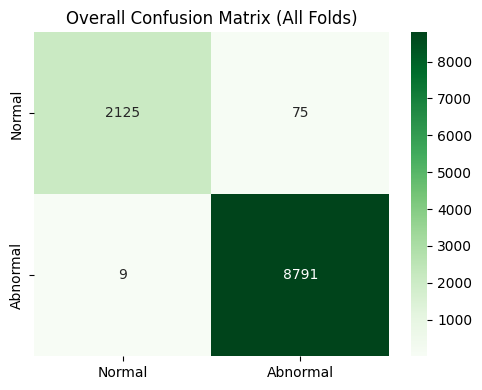

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, Dense, Dropout,
    LayerNormalization, Add, Bidirectional,
    GlobalAveragePooling1D
)
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.models import Model




# -------------------- Load Data --------------------
X = np.load(r"preprocessed\ALL_X.npy")
y = np.load(r"preprocessed\ALL_y.npy")

# Convert to binary: ICTAL = 0, ALL OTHERS = 1
y_encoded = np.where(y == 'ICTAL', 0, 1)

# Reshape for CNN input
X = X.reshape((X.shape[0], X.shape[1], 1))

print("Dataset shape:", X.shape)
print("Labels distribution:", np.unique(y_encoded, return_counts=True))

# -------------------- Prepare Cross Validation --------------------
random_state = np.random.randint(0, 10000)
print(f"🎲 Random state used for this run: {random_state}")

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
fold_indices = [(train_idx, test_idx) for train_idx, test_idx in kfold.split(X, y_encoded)]

os.makedirs("results(Interictal_VS_Normal_VS_Ictal)", exist_ok=True)
np.save("results(Interictal_VS_Normal_VS_Ictal)/fold_indices.npy", np.array(fold_indices, dtype=object), allow_pickle=True)

def hybrid_focal_loss(alpha=0.25, gamma=2.0, bce_weight=0.5):
    """
    Hybrid = BCE * bce_weight + FocalLoss * (1 - bce_weight)
    """

    def loss(y_true, y_pred):
        # --- Binary Cross Entropy ---
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        # --- Focal Loss ---
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        focal = -alpha * (1 - y_pred) ** gamma * y_true * K.log(y_pred) \
                - (1 - alpha) * y_pred ** gamma * (1 - y_true) * K.log(1 - y_pred)

        focal = K.mean(focal, axis=-1)

        # --- Combine Both ---
        return bce_weight * bce + (1 - bce_weight) * focal

    return loss

# -------------------- CNN + LSTM Model --------------------
def build_cnn_lstm(input_length):
    model = Sequential([
        # --- CNN Layers ---
        Conv1D(32, kernel_size=7, activation='relu', input_shape=(input_length, 1)),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.2),

        Conv1D(64, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.4),
        
        # --- LSTM ---
        LSTM(64, return_sequences=False),

        # --- Dense Layers ---
        Dense(64, activation='relu'),
        Dropout(0.4),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
    optimizer=Adam(1e-4),
    loss=hybrid_focal_loss(alpha=0.25, gamma=2.0, bce_weight=0.5),
    metrics=['accuracy']
    )
    return model


# -------------------- Data Augmentation for 1D EEG (Optimized Version) --------------------
def augment_signal(signal):
    # 1) Very Light Noise
    noise = np.random.normal(0, 0.005, signal.shape)
    signal_noisy = signal + noise

    # 2) Small Time Shift
    shift = np.random.randint(-5, 5)
    signal_shifted = np.roll(signal_noisy, shift)

    # 3) Gentle Scaling
    scale = np.random.uniform(0.97, 1.03)
    signal_scaled = signal_shifted * scale

    return signal_scaled



def augment_batch(X, y):
    X_aug = []
    y_aug = []

    for i in range(len(X)):
        X_aug.append(X[i])
        y_aug.append(y[i])

        # Generate **1 weakly augmented version**
        X_aug.append(augment_signal(X[i]))
        y_aug.append(y[i])

    return np.array(X_aug), np.array(y_aug)



# -------------------- Training --------------------
acc_per_fold = []
conf_matrices = []

for fold_no, (train_val_idx, test_idx) in enumerate(fold_indices, start=1):
    print(f"\n🔹 Fold {fold_no}")

    # Split into train/val/test
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y_encoded[train_val_idx], y_encoded[test_idx]

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.1765, stratify=y_train_val, random_state=42
    )

    # ------------ APPLY DATA AUGMENTATION ------------
    X_train, y_train = augment_batch(X_train, y_train)

    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # Build new model for each fold
    model = build_cnn_lstm(X_train.shape[1])
    model.summary()

    # Handle class imbalance
    cw = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {0: cw[0], 1: cw[1]}

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=40,
        batch_size=32,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        verbose=1
    )

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test)
    acc_per_fold.append(test_acc)
    print(f"Fold {fold_no} - Test Accuracy: {test_acc:.4f}")

    # Save weights
    weight_path = f"results(Interictal_VS_Normal_VS_Ictal)/cnn_lstm_fold{fold_no}.weights.h5"
    model.save_weights(weight_path)
    print(f"✅ Weights saved to {weight_path}")

    # Confusion matrix
    y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Normal', 'Abnormal'], 
        yticklabels=['Normal', 'Abnormal']
    )
    plt.title(f"Fold {fold_no} Confusion Matrix")
    plt.tight_layout()
    plt.savefig(f"results(Interictal_VS_Normal_VS_Ictal)/cnn_lstm_conf_fold{fold_no}.png")
    plt.close()

print("\n📊 Mean Accuracy:", np.mean(acc_per_fold))

# -------------------- Overall Confusion Matrix --------------------
total_cm = np.sum(conf_matrices, axis=0)

plt.figure(figsize=(5, 4))
sns.heatmap(
    total_cm, annot=True, fmt='d', cmap='Greens',
    xticklabels=['Normal', 'Abnormal'], 
    yticklabels=['Normal', 'Abnormal']
)
plt.title("Overall Confusion Matrix (All Folds)")
plt.tight_layout()
plt.savefig("results(Interictal_VS_Normal_VS_Ictal)/cnn_lstm_conf_overall.png")

tn, fp, fn, tp = total_cm.ravel()

overall_accuracy = (tp + tn) / np.sum(total_cm)
overall_precision = tp / (tp + fp)
overall_recall = tp / (tp + fn)
overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall)

print("\n📊 Overall Metrics:")
print(f"  Accuracy : {overall_accuracy:.4f}")
print(f"  Precision: {overall_precision:.4f}")
print(f"  Recall   : {overall_recall:.4f}")
print(f"  F1-score : {overall_f1:.4f}")

print("✅ CNN+LSTM Training Completed!")
